In [50]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [51]:

# Read the CSV file
csv_file_path = 'impact.csv'
data = pd.read_csv(csv_file_path)

In [52]:
def load_frame(video_path, frame_index, image_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Frame {frame_index} not found in video {video_path}")
    frame = cv2.resize(frame, image_size)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

def load_data(data, image_size=(224, 224)):
    frames_n_list = []
    frames_m_list = []
    perceived_changes = []
    for index, row in data.iterrows():
        video_path = row['Video']
        frame_n = int(row['Frame n'])
        frame_m = int(row['Frame m'])
        perceived_change = row['Perceived Change']
        
        frame_n = load_frame(video_path, frame_n, image_size)
        frame_m = load_frame(video_path, frame_m, image_size)
        
        frames_n_list.append(frame_n)
        frames_m_list.append(frame_m)
        perceived_changes.append(perceived_change)
    
    return frames_n_list, frames_m_list, perceived_changes

0.27592835


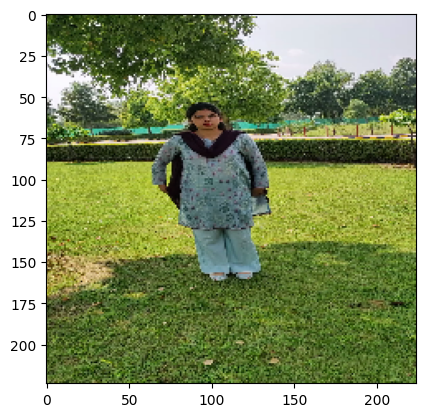

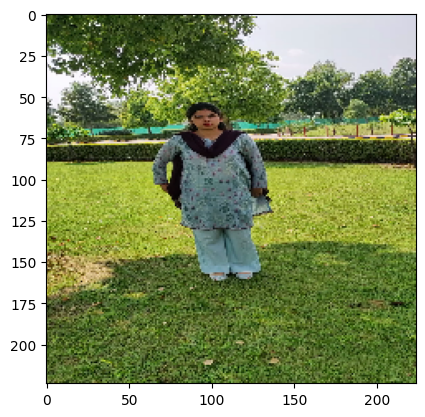

In [53]:
frames_n, frames_m, perceived_changes = load_data(data)

# Print the first n and m frame and the perceived change
print(perceived_changes[0])
plt.imshow(frames_n[0])
plt.show()
plt.imshow(frames_m[0])
plt.show()


In [54]:
# normalize the images
frames_n = np.array(frames_n) / 255.0
frames_m = np.array(frames_m) / 255.0
# Calculate the minimum and maximum values
min_value = np.min(perceived_changes)
max_value = np.max(perceived_changes)
# Apply Min-Max normalization
perceived_changes = (perceived_changes - min_value) / (max_value - min_value)

In [55]:
# Shuffle the data
indices = np.arange(len(perceived_changes))
np.random.shuffle(indices)

frames_n = tf.gather(frames_n, indices)
frames_m = tf.gather(frames_m, indices)
perceived_changes = tf.gather(perceived_changes, indices)

In [56]:
# Split the data into training, validation, and test sets
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Calculate the split indices
num_samples = len(perceived_changes)
train_end = int(train_ratio * num_samples)
val_end = train_end + int(val_ratio * num_samples)

# Split the data
frames_n_train = frames_n[:train_end]
frames_m_train = frames_m[:train_end]
perceived_changes_train = perceived_changes[:train_end]

frames_n_val = frames_n[train_end:val_end]
frames_m_val = frames_m[train_end:val_end]
perceived_changes_val = perceived_changes[train_end:val_end]

frames_n_test = frames_n[val_end:]
frames_m_test = frames_m[val_end:]
perceived_changes_test = perceived_changes[val_end:]




In [57]:
frames_m_test.shape

TensorShape([6, 224, 224, 3])

In [58]:
# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(((frames_n_train, frames_m_train), perceived_changes_train))
val_dataset = tf.data.Dataset.from_tensor_slices(((frames_n_val, frames_m_val), perceived_changes_val))
test_dataset = tf.data.Dataset.from_tensor_slices(((frames_n_test, frames_m_test), perceived_changes_test))

# Shuffle and batch the dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(perceived_changes)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [59]:
# Define the neural network model
input_n = tf.keras.layers.Input(shape=(224, 224, 3))
input_m = tf.keras.layers.Input(shape=(224, 224, 3))

# Shared convolutional base
base_model = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x_n = base_model(input_n)
x_m = base_model(input_m)

# Global average pooling
x_n = tf.keras.layers.GlobalAveragePooling2D()(x_n)
x_m = tf.keras.layers.GlobalAveragePooling2D()(x_m)

# Concatenate the outputs
x = tf.keras.layers.Concatenate()([x_n, x_m])

# Fully connected layer
x = tf.keras.layers.Dense(128, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.models.Model(inputs=[input_n, input_m], outputs=output)



4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [60]:
model.trainable_variables


[<KerasVariable shape=(1152, 128), dtype=float32, path=dense_8/kernel>,
 <KerasVariable shape=(128,), dtype=float32, path=dense_8/bias>,
 <KerasVariable shape=(128, 1), dtype=float32, path=dense_9/kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=dense_9/bias>]

In [61]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Small    │ (None, 7, 7, 576) │    939,120 │ input_layer_12[0… │
│ (Functional)        │                   │            │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 576)       │          0 │ MobileNetV3Small… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 576)       │          0 │ MobileNetV3Small… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 1152)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │    147,584 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        129 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,086,833 (4.15 MB)

 Trainable params: 147,713 (577.00 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [62]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
epochs = 10
model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/10


/workspaces/FrameGate/myenv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_736', 'keras_tensor_737']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2509 - mae: 0.3954 - val_loss: 0.7394 - val_mae: 0.7825
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.6648 - mae: 0.7529 - val_loss: 0.2753 - val_mae: 0.3857
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2240 - mae: 0.4144 - val_loss: 0.1556 - val_mae: 0.3531
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1384 - mae: 0.2780 - val_loss: 0.3538 - val_mae: 0.4780
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.3556 - mae: 0.5089 - val_loss: 0.2983 - val_mae: 0.4158
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.2962 - mae: 0.4467 - val_loss: 0.1463 - val_mae: 0.3530
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1273 - mae: 0.2708 - val_loss: 0.1563 - val_mae: 0.3536
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1178 - mae: 0.3089 - val_loss: 0.2736 - val_mae: 0.3837
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.2224 - mae: 0.4130 - val_l

In [63]:
test_loss, test_mae = model.evaluate(test_dataset)
print(f'Test loss: {test_loss}')
print(f'Test MAE: {test_mae}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1011 - mae: 0.2593
Test loss: 0.10107053071260452
Test MAE: 0.25927022099494934
